In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# Primeiro projeto com machine learning
## Preparando os dados
Primeiro vamos carregar os dados usando pandas

In [2]:
house = pd.read_csv('datasets\housing.csv')
house

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Rápida visualização dos dados que vamos trabalhar

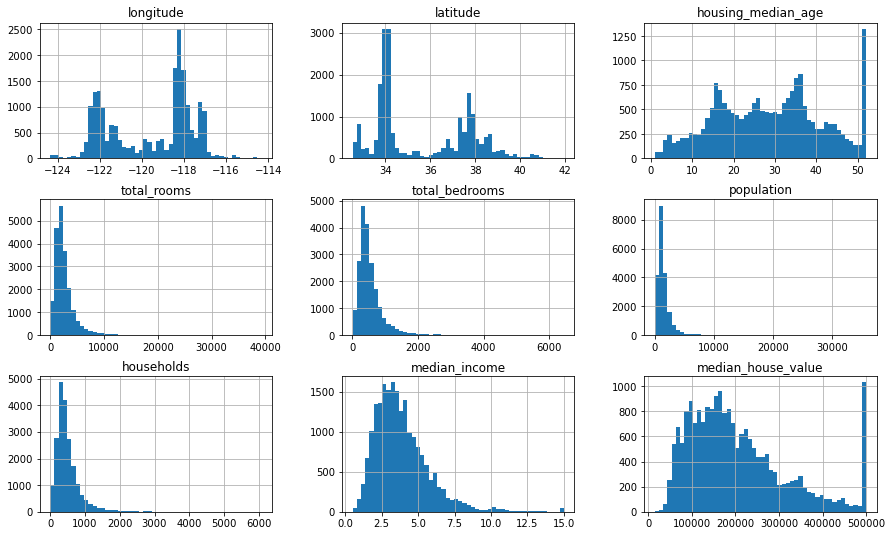

In [6]:
house.hist(bins=50, figsize=(15, 9))
plt.show()

Funação para **separar** os dados em **dados de teste** e **dados de treinamento**

In [18]:
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Aplicando a função nos dados 

In [19]:
train_set, test_set = split_train_test(house, 0.2)
len(train_set), len(test_set)

(16512, 4128)

O problema é que cada vez que rodarmos a célula teremos valores diferentes. Como não queremos isso iremos usar um truque para que uma vez rodada a função *split_train_test()* os valores de treino e teste fiquem constantes.

In [28]:
from zlib import crc32

def test_set_check(identifier, teste_ratio):
    return crc32(np.int64(identifier)) & 0xfffffff <teste_ratio*2**32

def split_train_test_by_id(data, teste_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, teste_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

house_with_id = house.reset_index()
train_set, test_set = split_train_test_by_id(house_with_id, 0.2, 'index')

house_with_id['id'] = house['longitude'] * 1000 + house['latitude']
train_set, test_set = split_train_test_by_id(house_with_id, 0.2, 'id')

Iremos usar da *train_test_split()* da biblioteca sklearn para separar os dados de maneira aleatória.

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(house, test_size=0.2, random_state=42)

Contudo é importante lembrar que os dados podem ter erros de bias, como por exemplo os dados serem afetados pela renda. Por isso é importate garantir que os dados de treino e teste são representativos. Dessa forma vamos agrupar por categorias de renda.

<AxesSubplot:>

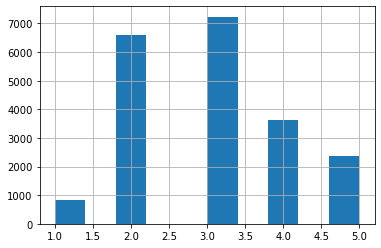

In [62]:
house['income_cat'] = pd.cut(house['median_income'], 
                            bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                            labels=[1, 2, 3, 4, 5])

house['income_cat'].hist()                            

Usando a função *StratifiedShuffleSplit()* será garantido que será pego amostras de traino e teste representativas dentro do conjunto de dados do atributo renda (income_cat).

In [70]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(house, house['income_cat']):
    strat_train_set = house.loc[train_index]
    strat_test_set = house.loc[test_index]

#Tirando a coluna income_cat p/ voltar nos dados originais
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)


## Visualizando os dados

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

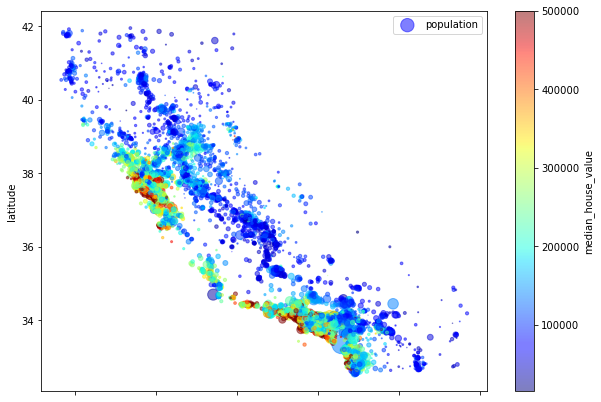

In [104]:
housing = strat_train_set.copy()

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, 
            s=housing['population']/100, label='population', figsize=(10,7), 
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

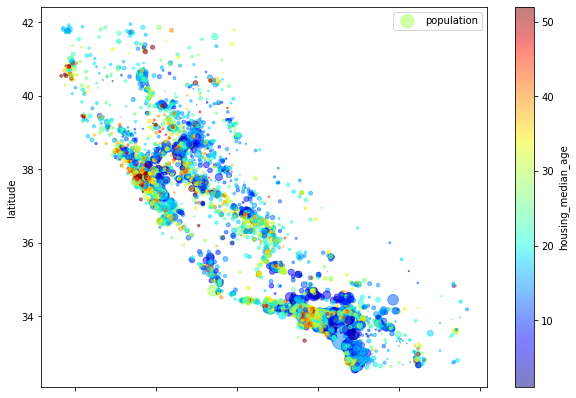

In [84]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, 
            s=housing['population']/100, label='population', figsize=(10,7), 
            c='housing_median_age', cmap=plt.get_cmap('jet'), colorbar=True)